<a href="https://colab.research.google.com/github/maryem-ahmed/Credit-Card-Fraud-Detection_Unsupervised-Learning-for-Anomaly-Detection/blob/master/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import folium

In [2]:
info_cars = pd.read_csv('/content/cc_info.csv')
info_trans = pd.read_csv('/content/transactions.csv.zip')

In [3]:
info_cars.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
info_trans.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
#missing values
info_cars.isnull().sum()


,0
credit_card,0
city,0
state,0
zipcode,0
credit_card_limit,0


In [6]:
info_trans.isnull().sum()

,0
credit_card,0
date,0
transaction_dollar_amount,0
Long,0
Lat,0


In [7]:
#im thinking of merging the two dataframes
df = pd.merge(info_trans, info_cars, on='credit_card')

In [8]:
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [9]:
df.describe()

,credit_card,transaction_dollar_amount,Long,Lat,zipcode,credit_card_limit
count,2.945880e+05,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669,18073.772516,15502.053716
std,2.555803e+15,124.655954,20.135015,5.391695,23945.510551,7956.291556
min,1.003715e+15,0.010000,-179.392887,-68.046553,690.000000,2000.000000
25%,3.344214e+15,29.970000,-80.209708,40.487726,3280.000000,10000.000000
50%,5.353426e+15,58.470000,-73.199737,42.403066,5820.000000,15000.000000
75%,7.646245e+15,100.400000,-72.091933,43.180015,18612.000000,20000.000000
max,9.999757e+15,999.970000,179.917513,78.914330,98401.000000,55000.000000


In [10]:
df.shape

(294588, 9)

In [11]:
class FraudDetectionModel:
    def __init__(self, df):
        self.df = df
        self.feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit']
        self.model = None
        self.kmeans = None

    def data_preprocessing(self):
        scaler = StandardScaler()
        self.df[self.feature_columns] = scaler.fit_transform(self.df[self.feature_columns])

    def build_kmeans(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def create_labels(self):
        if self.kmeans is None:
            raise ValueError("K-means model has not been built yet. Please call 'build_kmeans' first.")

        self.kmeans.fit(self.df[self.feature_columns])

        self.df['cluster_label'] = self.kmeans.predict(self.df[self.feature_columns])

        cluster_fraud_label = self.df.groupby('cluster_label')['transaction_dollar_amount'].mean().idxmax()
        self.df['is_fraudulent'] = self.df['cluster_label'].apply(lambda x: 1 if x == cluster_fraud_label else 0)


    def visualize_fraudulent_transactions(self):
        plt.figure(figsize=(15, 8))
        sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount', hue = 'is_fraudulent')
        plt.title('Credit Card Limit vs. Transaction Dollar Amount')
        plt.xlabel('Credit Card Limit')
        plt.ylabel('Transaction Dollar Amount')
        plt.show()

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(len(self.feature_columns),)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train, y_train, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)

        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


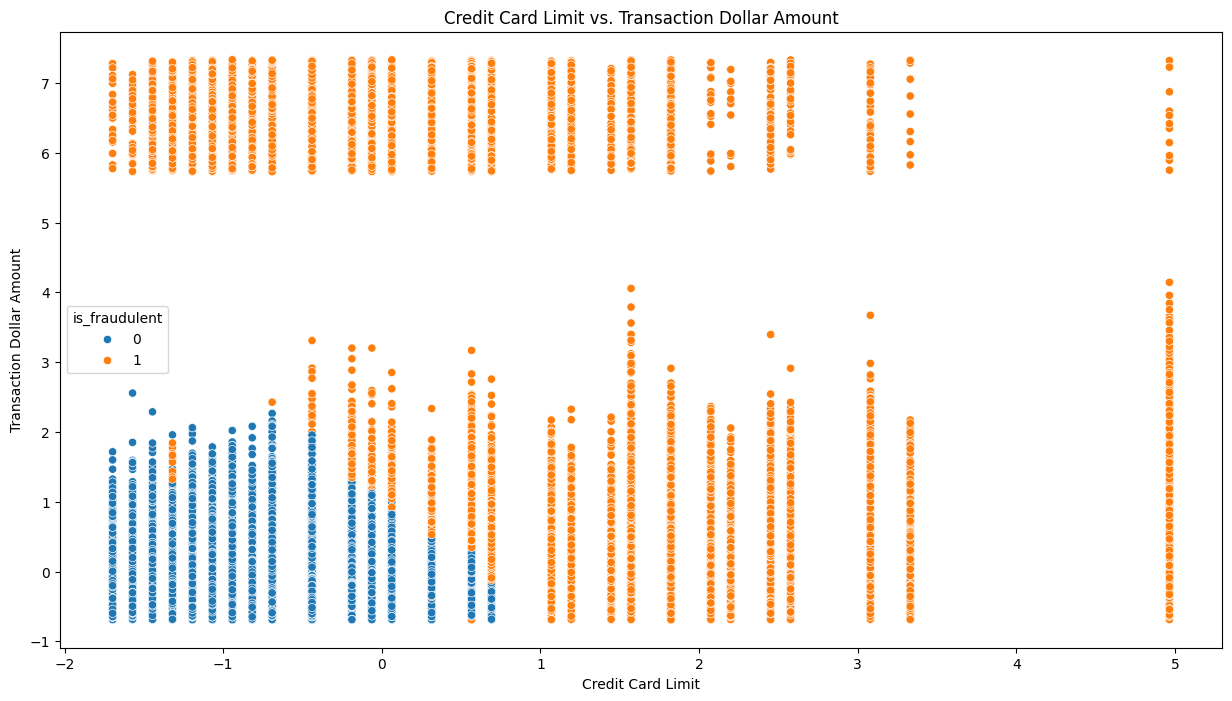

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Training Complete.
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9993 - loss: 0.0021
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44739
           1       1.00      1.00      1.00     14179

    accuracy                           1.00     58918
   macro avg       1.00      1.00      1.00     58918
weighted avg       1.00      1.00      1.00     58918

Confusion Matrix:
[[44706    33]
 [    8 14171]]


In [12]:
if __name__ == "__main__":

    model = FraudDetectionModel(df)
    model.data_preprocessing()
    model.build_kmeans()
    model.create_labels()

    model.visualize_fraudulent_transactions()

    X = model.df[model.feature_columns].values
    y = model.df['is_fraudulent'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.build_model()
    model.train_model(X_train, y_train, epochs=10, batch_size=32)

    print("Model Training Complete.")

    model.evaluate_model(X_test, y_test)

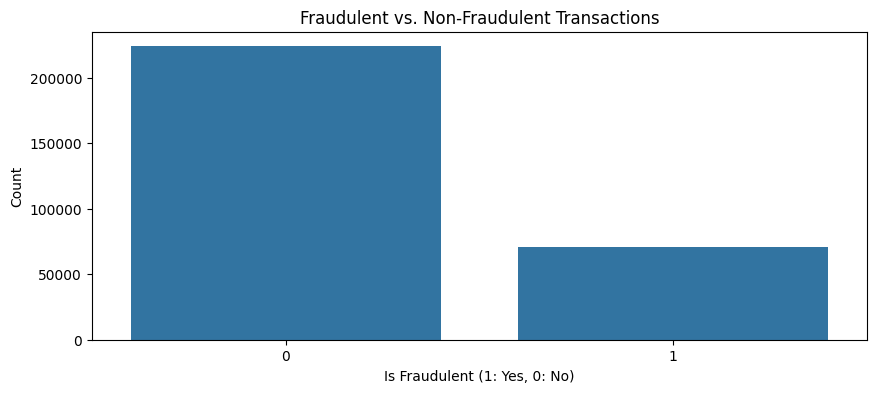

In [13]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='is_fraudulent')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraudulent (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()